参考：
- http://aidiary.hatenablog.com/entry/20180304/1520172429
- https://github.com/cross32768/VGAN/blob/master/VGAN.ipynb

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [4]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter):

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        # 訓練モードへ
        D.train()
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetachする。
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- ここから
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- ここまで
        
        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images) # Dに判別してもらう！
        G_loss = G_criterion(D_fake, y_real) # 本物が多いとloss小。
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        # TensorBoardX
        writer.add_scalar('train_G_loss', G_loss.item(), num_iter)
        writer.add_scalar('train_D_loss', D_loss.item(), num_iter)
        writer.add_scalar('beta', beta, num_iter)
        if num_iter % 50 == 0:
            G.eval()
            sample_z = torch.rand((64, z_dim)).to(device)
            with torch.no_grad():
                sample = G(sample_z).to('cpu')
            writer.add_image('Image_from_latent', make_grid(sample, nrow=8, padding=1), num_iter)
        num_iter += 1
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, num_iter, beta

In [5]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [6]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 100
sample_num = 16
log_dir = './logs/vgan'

In [7]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

(-0.5, 145.5, 145.5, -0.5)

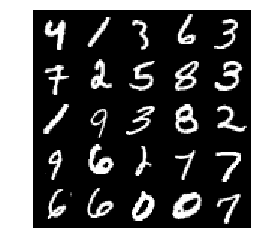

In [8]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1x28x28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- ここから
        self.conv_mus = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        self.conv_sigmas = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        # -------------------------------- ここまで
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- ここから
        mus = self.conv_mus(x).view(-1, 128 * 7 * 7) # mean
        sigmas = self.conv_sigmas(x).view(-1, 128 * 7 * 7) # logvar
        noise = torch.randn(mus.size(), device=device)
        z = (0.5 * sigmas).exp() * noise + mus
        # -------------------------------- ここまで
        
        x = self.fc(z)
        return x, mus, sigmas

In [10]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- ここから
I_c = 0.1
beta = 0 #1.0
alpha = 1e-5

def VDB_loss(out, label, mean, sigma, beta):
    normal_D_loss = torch.mean(F.binary_cross_entropy(out, label))
    
    kldiv_loss = - 0.5 * torch.mean(1 + sigma - mean.pow(2) - sigma.exp())
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
# -------------------------------- ここまで

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

In [12]:
writer = SummaryWriter()

history = {}
history['D_loss'] = []
history['G_loss'] = []
num_iter = 0

for epoch in range(num_epochs):
    D_loss, G_loss, num_iter, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # Generatorから画像を生成してモデルも保存
    generate(epoch + 1, G, log_dir)
    torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
    torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

100%|██████████| 468/468 [00:23<00:00, 19.54it/s]


epoch 1, D_loss: 1.3885 G_loss: 0.6943


  0%|          | 2/468 [00:00<00:25, 18.31it/s]

epoch 2, D_loss: 1.3869 G_loss: 0.6934


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 3, D_loss: 1.3867 G_loss: 0.6933


  0%|          | 2/468 [00:00<00:23, 19.81it/s]

epoch 4, D_loss: 1.3866 G_loss: 0.6933


  0%|          | 2/468 [00:00<00:25, 17.93it/s]

epoch 5, D_loss: 1.3865 G_loss: 0.6933


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 6, D_loss: 1.3865 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 7, D_loss: 1.3865 G_loss: 0.6933


  0%|          | 2/468 [00:00<00:24, 19.38it/s]

epoch 8, D_loss: 1.3864 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 9, D_loss: 1.3864 G_loss: 0.6933


  0%|          | 2/468 [00:00<00:23, 19.71it/s]

epoch 10, D_loss: 1.3864 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 11, D_loss: 1.3864 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 12, D_loss: 1.3824 G_loss: 0.6966


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 13, D_loss: 1.2497 G_loss: 0.8230


  0%|          | 2/468 [00:00<00:27, 17.11it/s]

epoch 14, D_loss: 1.1396 G_loss: 0.9545


  0%|          | 2/468 [00:00<00:24, 19.30it/s]

epoch 15, D_loss: 1.0862 G_loss: 1.0454


  0%|          | 2/468 [00:00<00:23, 19.47it/s]

epoch 16, D_loss: 1.0494 G_loss: 1.1098


100%|██████████| 468/468 [00:23<00:00, 19.71it/s]


epoch 17, D_loss: 1.0023 G_loss: 1.1782


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 18, D_loss: 0.9857 G_loss: 1.2362


  0%|          | 2/468 [00:00<00:24, 18.71it/s]

epoch 19, D_loss: 0.9616 G_loss: 1.2814


  0%|          | 2/468 [00:00<00:23, 19.86it/s]

epoch 20, D_loss: 0.9368 G_loss: 1.3139


  0%|          | 2/468 [00:00<00:24, 19.14it/s]

epoch 21, D_loss: 0.9151 G_loss: 1.3648


  0%|          | 2/468 [00:00<00:24, 19.04it/s]

epoch 22, D_loss: 0.9045 G_loss: 1.4147


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 23, D_loss: 0.9142 G_loss: 1.4213


100%|██████████| 468/468 [00:22<00:00, 20.36it/s]


epoch 24, D_loss: 0.8735 G_loss: 1.4573


  0%|          | 2/468 [00:00<00:26, 17.91it/s]

epoch 25, D_loss: 0.8764 G_loss: 1.4798


100%|██████████| 468/468 [00:23<00:00, 19.58it/s]


epoch 26, D_loss: 0.8802 G_loss: 1.5039


  0%|          | 2/468 [00:00<00:23, 19.62it/s]

epoch 27, D_loss: 0.8707 G_loss: 1.5153


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 28, D_loss: 0.8505 G_loss: 1.5491


  0%|          | 2/468 [00:00<00:23, 19.89it/s]

epoch 29, D_loss: 0.8440 G_loss: 1.5580


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 30, D_loss: 0.8538 G_loss: 1.5779


  1%|          | 3/468 [00:00<00:22, 20.60it/s]

epoch 31, D_loss: 0.8361 G_loss: 1.6034


  0%|          | 2/468 [00:00<00:24, 18.70it/s]

epoch 32, D_loss: 0.8341 G_loss: 1.6162


  0%|          | 2/468 [00:00<00:24, 19.26it/s]

epoch 33, D_loss: 0.8238 G_loss: 1.6294


  0%|          | 2/468 [00:00<00:24, 18.81it/s]

epoch 34, D_loss: 0.8190 G_loss: 1.6397


  1%|          | 3/468 [00:00<00:22, 21.07it/s]

epoch 35, D_loss: 0.8077 G_loss: 1.7025


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 36, D_loss: 0.7991 G_loss: 1.7250


  1%|          | 3/468 [00:00<00:22, 20.99it/s]

epoch 37, D_loss: 0.7936 G_loss: 1.7207


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 38, D_loss: 0.7756 G_loss: 1.7645


  1%|          | 3/468 [00:00<00:22, 21.13it/s]

epoch 39, D_loss: 0.7807 G_loss: 1.7657


  1%|          | 3/468 [00:00<00:22, 20.90it/s]

epoch 40, D_loss: 0.7643 G_loss: 1.7993


  0%|          | 2/468 [00:00<00:23, 19.57it/s]

epoch 41, D_loss: 0.7523 G_loss: 1.8237


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 42, D_loss: 0.7604 G_loss: 1.8339


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 43, D_loss: 0.7547 G_loss: 1.8377


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 44, D_loss: 0.7420 G_loss: 1.8873


  1%|          | 3/468 [00:00<00:22, 20.97it/s]

epoch 45, D_loss: 0.7490 G_loss: 1.9071


  0%|          | 2/468 [00:00<00:25, 18.62it/s]

epoch 46, D_loss: 0.7308 G_loss: 1.9259


  0%|          | 2/468 [00:00<00:24, 19.01it/s]

epoch 47, D_loss: 0.7354 G_loss: 1.9113


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 48, D_loss: 0.7406 G_loss: 1.9615


  0%|          | 2/468 [00:00<00:23, 19.93it/s]

epoch 49, D_loss: 0.7121 G_loss: 1.9671


  0%|          | 2/468 [00:00<00:24, 18.94it/s]

epoch 50, D_loss: 0.7140 G_loss: 2.0056


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 51, D_loss: 0.7156 G_loss: 2.0192


  1%|          | 3/468 [00:00<00:22, 20.77it/s]

epoch 52, D_loss: 0.7134 G_loss: 2.0246


  1%|          | 3/468 [00:00<00:22, 20.70it/s]

epoch 53, D_loss: 0.7150 G_loss: 2.0565


100%|██████████| 468/468 [00:22<00:00, 20.52it/s]


epoch 54, D_loss: 0.7166 G_loss: 2.0297


  0%|          | 2/468 [00:00<00:23, 19.92it/s]

epoch 55, D_loss: 0.6938 G_loss: 2.0600


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 56, D_loss: 0.6964 G_loss: 2.0574


  1%|          | 3/468 [00:00<00:22, 20.61it/s]

epoch 57, D_loss: 0.6896 G_loss: 2.0729


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 58, D_loss: 0.6850 G_loss: 2.1123


  1%|          | 3/468 [00:00<00:22, 20.48it/s]

epoch 59, D_loss: 0.7073 G_loss: 2.0949


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 60, D_loss: 0.6829 G_loss: 2.1207


  1%|          | 3/468 [00:00<00:23, 19.78it/s]

epoch 61, D_loss: 0.6875 G_loss: 2.1332


  1%|          | 3/468 [00:00<00:22, 20.77it/s]

epoch 62, D_loss: 0.6904 G_loss: 2.1460


  1%|          | 3/468 [00:00<00:22, 20.99it/s]

epoch 63, D_loss: 0.6558 G_loss: 2.1648


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 64, D_loss: 0.6831 G_loss: 2.2057


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 65, D_loss: 0.6821 G_loss: 2.1994


  0%|          | 2/468 [00:00<00:24, 19.34it/s]

epoch 66, D_loss: 0.6596 G_loss: 2.1837


  0%|          | 2/468 [00:00<00:25, 18.44it/s]

epoch 67, D_loss: 0.6626 G_loss: 2.2184


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 68, D_loss: 0.6689 G_loss: 2.2129


  0%|          | 2/468 [00:00<00:25, 18.15it/s]

epoch 69, D_loss: 0.6599 G_loss: 2.2336


  0%|          | 2/468 [00:00<00:25, 18.56it/s]

epoch 70, D_loss: 0.6498 G_loss: 2.2320


  0%|          | 2/468 [00:00<00:23, 19.93it/s]

epoch 71, D_loss: 0.6635 G_loss: 2.2594


100%|██████████| 468/468 [00:23<00:00, 19.93it/s]


epoch 72, D_loss: 0.6545 G_loss: 2.2586


  1%|          | 3/468 [00:00<00:22, 20.77it/s]

epoch 73, D_loss: 0.6617 G_loss: 2.2837


100%|██████████| 468/468 [00:23<00:00, 19.86it/s]


epoch 74, D_loss: 0.6593 G_loss: 2.2922


  0%|          | 2/468 [00:00<00:26, 17.83it/s]

epoch 75, D_loss: 0.6793 G_loss: 2.2755


  0%|          | 2/468 [00:00<00:23, 19.98it/s]

epoch 76, D_loss: 0.6638 G_loss: 2.2732


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 77, D_loss: 0.6538 G_loss: 2.2979


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 78, D_loss: 0.6559 G_loss: 2.2734


  1%|          | 3/468 [00:00<00:22, 20.55it/s]

epoch 79, D_loss: 0.6451 G_loss: 2.3189


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 80, D_loss: 0.6515 G_loss: 2.3128


  0%|          | 2/468 [00:00<00:23, 20.00it/s]

epoch 81, D_loss: 0.6386 G_loss: 2.3258


  0%|          | 2/468 [00:00<00:23, 19.71it/s]

epoch 82, D_loss: 0.6524 G_loss: 2.3184


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 83, D_loss: 0.6413 G_loss: 2.3444


100%|██████████| 468/468 [00:23<00:00, 20.04it/s]


epoch 84, D_loss: 0.6466 G_loss: 2.3384


  1%|          | 3/468 [00:00<00:22, 21.00it/s]

epoch 85, D_loss: 0.6483 G_loss: 2.3460


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 86, D_loss: 0.6436 G_loss: 2.3613


  1%|          | 3/468 [00:00<00:22, 21.00it/s]

epoch 87, D_loss: 0.6551 G_loss: 2.3895


  0%|          | 2/468 [00:00<00:24, 18.82it/s]

epoch 88, D_loss: 0.6280 G_loss: 2.4019


  0%|          | 2/468 [00:00<00:23, 19.98it/s]

epoch 89, D_loss: 0.6373 G_loss: 2.3793


  0%|          | 2/468 [00:00<00:23, 19.93it/s]

epoch 90, D_loss: 0.6372 G_loss: 2.4448


  1%|          | 3/468 [00:00<00:22, 20.53it/s]

epoch 91, D_loss: 0.6312 G_loss: 2.4415


  1%|          | 3/468 [00:00<00:22, 20.59it/s]

epoch 92, D_loss: 0.6357 G_loss: 2.4569


  0%|          | 2/468 [00:00<00:24, 19.25it/s]

epoch 93, D_loss: 0.6308 G_loss: 2.4091


  0%|          | 2/468 [00:00<00:24, 18.87it/s]

epoch 94, D_loss: 0.6464 G_loss: 2.4387


  0%|          | 2/468 [00:00<00:24, 18.66it/s]

epoch 95, D_loss: 0.6078 G_loss: 2.4571


  1%|          | 3/468 [00:00<00:22, 20.52it/s]

epoch 96, D_loss: 0.6245 G_loss: 2.4384


  1%|          | 3/468 [00:00<00:22, 20.72it/s]

epoch 97, D_loss: 0.6312 G_loss: 2.4486


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 98, D_loss: 0.6354 G_loss: 2.4615


  0%|          | 2/468 [00:00<00:23, 19.84it/s]

epoch 99, D_loss: 0.6123 G_loss: 2.4655


100%|██████████| 468/468 [00:23<00:00, 19.91it/s]

epoch 100, D_loss: 0.6317 G_loss: 2.4631


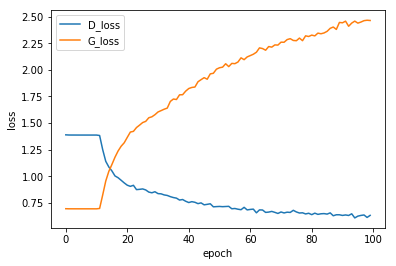

In [13]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

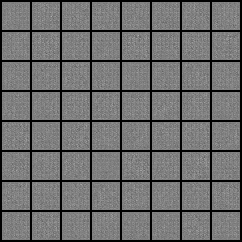

In [14]:
from IPython.display import Image
Image('logs/vgan/epoch_001.png')

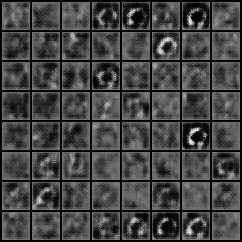

In [15]:
Image('logs/vgan/epoch_010.png')

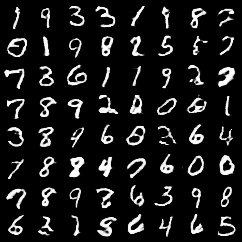

In [21]:
Image('logs/vgan/epoch_015.png')

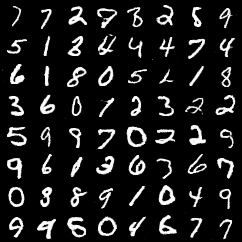

In [24]:
Image('logs/vgan/epoch_100.png')